## Driver code comparing output of different atlas / parcellations 

### Steps
- import data csvs 
- visualize data distributions 
- correlate features across pipelines
- compare performance of machine-learning model (scikit-learn)
- compare performance of statsmodels (ols or logit)

In [1]:
import sys
import numpy as np
import pandas as pd
import itertools
from sklearn import svm
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../')
from lib.data_handling import *
from lib.data_stats import *

### Data paths

In [2]:
proj_dir = '/Users/nikhil/code/git_repos/compare-surf-tools/'
data_dir = proj_dir + 'data/'
fs60_dir = data_dir + 'fs60_group_stats/'
demograph_file = 'ABIDE_Phenotype.csv'

#fs60 all files
# Thickness
fs60_aparc_lh_thickness_file = 'lh.aparc.thickness.table.test1'
fs60_aparc_rh_thickness_file = 'rh.aparc.thickness.table.test1' #34 ROIs
fs60_aparc2009_lh_thickness_file = 'lh.aparc.a2009.thickness.table.test1' #74 ROIs per hemi
fs60_aparc2009_rh_thickness_file = 'rh.aparc.a2009.thickness.table.test1'
fs60_glasser_lh_thickness_file = 'lh.glasser.thickness.table.test1' #180 ROIs per hemi
fs60_glasser_rh_thickness_file = 'rh.glasser.thickness.table.test1'


# Surface Area
# fs60_aparc_lh_SA_file = 'aparc_lh_SA_table.test1'
# fs60_aparc_rh_SA_file = 'aparc_rh_SA_table.test1'
# fs60_aparc2009_lh_SA_file = 'lh.aparc.a2009.SA.table.test1'
# fs60_aparc2009_rh_SA_file = 'rh.aparc.a2009.SA.table.test1'


### Global Vars

In [3]:
subject_ID_col = 'SubjID'

### Load data

In [4]:
# Demographics and Dx
demograph = pd.read_csv(data_dir + demograph_file)
demograph = demograph.rename(columns={'Subject_ID':subject_ID_col})

# aparc
aparc = 'aparc'
fs60_aparc_lh_thickness_data = pd.read_csv(fs60_dir + fs60_aparc_lh_thickness_file, delim_whitespace=True)
fs60_aparc_rh_thickness_data = pd.read_csv(fs60_dir + fs60_aparc_rh_thickness_file, delim_whitespace=True)
print('shape of fs60 aparc data l: {}, r: {}'.format(fs60_aparc_lh_thickness_data.shape,fs60_aparc_rh_thickness_data.shape))
fs60_aparc_thickness_data_std = standardize_fs60_data(fs60_aparc_lh_thickness_data, 
                                                      fs60_aparc_rh_thickness_data, subject_ID_col, aparc)
print('shape of stdized fs60 aparc data {}'.format(fs60_aparc_thickness_data_std.shape))


# Destrieux
aparc = 'aparc.a2009s'
fs60_aparc2009_lh_thickness_data = pd.read_csv(fs60_dir + fs60_aparc2009_lh_thickness_file, delim_whitespace=True)
fs60_aparc2009_rh_thickness_data = pd.read_csv(fs60_dir + fs60_aparc2009_rh_thickness_file, delim_whitespace=True)
print('shape of fs60 aparc2009 data l: {}, r: {}'.format(fs60_aparc2009_lh_thickness_data.shape,fs60_aparc2009_rh_thickness_data.shape))
fs60_aparc2009_thickness_data_std = standardize_fs60_data(fs60_aparc2009_lh_thickness_data,
                                                          fs60_aparc2009_rh_thickness_data, subject_ID_col, aparc)
print('shape of stdized fs60 aparc data {}'.format(fs60_aparc2009_thickness_data_std.shape))


# Glasser
aparc = 'aparc.Glasseratlas'
fs60_glasser_lh_thickness_data = pd.read_csv(fs60_dir + fs60_glasser_lh_thickness_file, delim_whitespace=True)
fs60_glasser_rh_thickness_data = pd.read_csv(fs60_dir + fs60_glasser_rh_thickness_file, delim_whitespace=True)
print('shape of fs60 glasser data l: {}, r: {}'.format(fs60_glasser_lh_thickness_data.shape,fs60_glasser_rh_thickness_data.shape))
fs60_glasser_thickness_data_std = standardize_fs60_data(fs60_glasser_lh_thickness_data,
                                                          fs60_glasser_rh_thickness_data, subject_ID_col, aparc)
print('shape of stdized fs60 aparc data {}'.format(fs60_glasser_thickness_data_std.shape))


shape of fs60 aparc data l: (1047, 36), r: (1047, 36)
shape of left and right merge fs6.0 df (1047, 71)
shape of stdized fs60 aparc data (1047, 71)
shape of fs60 aparc2009 data l: (1047, 76), r: (1047, 76)
shape of left and right merge fs6.0 df (1047, 151)
shape of stdized fs60 aparc data (1047, 151)
shape of fs60 glasser data l: (1047, 182), r: (1047, 182)
shape of left and right merge fs6.0 df (1047, 363)
shape of stdized fs60 aparc data (1047, 363)


In [7]:
fs60_aparc2009_thickness_data_std

,SubjID,L_G&S_frontomargin,L_G&S_occipital_inf,L_G&S_paracentral,L_G&S_subcentral,L_G&S_transv_frontopol,L_G&S_cingul-Ant,L_G&S_cingul-Mid-Ant,L_G&S_cingul-Mid-Post,L_G_cingul-Post-dorsal,...,R_S_pericallosal,R_S_postcentral,R_S_precentral-inf-part,R_S_precentral-sup-part,R_S_suborbital,R_S_subparietal,R_S_temporal_inf,R_S_temporal_sup,R_S_temporal_transverse,rh_MeanThickness_thickness
0,0050002,2.445,2.608,2.687,2.955,2.552,2.949,3.013,2.854,3.090,...,1.748,2.197,2.653,2.586,2.244,2.615,2.819,2.602,2.770,2.66390
1,0050003,2.409,2.573,2.200,2.635,2.777,3.034,2.762,2.824,3.162,...,2.144,2.246,2.435,2.452,3.140,2.860,2.281,2.497,2.704,2.49413
2,0050004,2.460,2.850,2.568,2.863,2.911,2.697,2.922,2.732,3.200,...,1.687,2.325,2.476,2.679,2.440,2.658,2.578,2.620,2.216,2.63963
3,0050006,2.889,2.774,2.489,3.058,3.044,2.971,2.994,3.195,3.155,...,1.551,2.503,2.766,2.804,2.997,2.694,2.570,2.919,3.120,2.79477
4,0050007,2.094,2.382,2.283,2.758,2.661,2.624,2.661,2.839,2.930,...,2.058,2.079,2.475,2.402,1.932,2.246,2.427,2.427,2.527,2.42719
5,0050008,2.235,2.460,2.444,2.589,2.408,2.774,2.593,2.517,3.020,...,2.141,2.024,2.437,2.525,2.558,2.384,2.549,2.679,2.629,2.48563
6,0050009,2.328,2.206,2.360,2.771,2.620,2.735,2.362,2.409,2.774,...,1.826,2.221,2.485,2.539,2.419,2.474,2.446,2.487,1.897,2.49109
7,0050010,2.890,2.428,2.603,2.563,3.001,3.023,2.992,2.561,3.060,...,2.592,2.087,2.467,2.434,2.887,2.758,2.628,2.443,2.284,2.54681
8,0050011,2.389,2.380,2.776,2.813,2.647,2.768,2.551,2.579,3.074,...,1.648,2.102,2.502,2.613,2.311,2.468,2.514,2.460,1.878,2.52381
9,0050012,2.483,2.491,2.285,2.783,2.961,2.966,2.582,2.610,3.235,...,2.428,2.256,2.434,2.318,2.139,2.406,2.429,2.623,2.784,2.56422


### Create master dataframe

In [8]:
data_dict = {'aparc' : fs60_aparc_thickness_data_std,
            'Destrieux' : fs60_aparc2009_thickness_data_std,
            'Glasser' : fs60_glasser_thickness_data_std}

# Add demographic columns to the master_df
useful_demograph = demograph[[subject_ID_col,'SEX','AGE_AT_SCAN','DX_GROUP']].copy()
_,useful_demograph[subject_ID_col] = useful_demograph[subject_ID_col].str.split('_', 1).str

### Compare ML performance 

In [9]:
outcome_col = 'DX_GROUP'
clf = svm.SVC(kernel='linear')
ml_perf_dict = {}

for atlas in data_dict.keys():
    master_df = pd.merge(useful_demograph,data_dict[atlas],on= subject_ID_col)
    input_cols = master_df.filter(regex='^L|R_', axis=1).columns
    master_df['pipeline'] = np.tile(atlas,len(master_df))
    ml_perf = getClassiferPerf(master_df,input_cols,outcome_col,clf)
    ml_perf_dict[atlas] = ml_perf

Running ML classifer on 1 pipelines
Pipeline aparc,  Accuracy mean:0.545, sd:0.057
Running ML classifer on 1 pipelines
Pipeline Destrieux,  Accuracy mean:0.528, sd:0.052
Running ML classifer on 1 pipelines
Pipeline Glasser,  Accuracy mean:0.522, sd:0.059



### Compare statsmodels performance 

In [23]:
covar_cols = ['AGE_AT_SCAN','DX_GROUP']
outcome_col = 'SEX' #AGE_AT_SCAN #DX_GROUP #SEX
stat_model = 'logit' #OLS #Logit
stat_perf_dict = {}

for atlas in data_dict.keys():
    master_df = pd.merge(useful_demograph,data_dict[atlas],on= subject_ID_col)
    input_cols = master_df.filter(regex='^L|R_', axis=1).columns
    master_df['pipeline'] = np.tile(atlas,len(master_df))
    sm_perf = getStatModelPerf(master_df,input_cols,covar_cols,outcome_col,stat_model)
    stat_perf_dict[atlas] = sm_perf
    print('Shape of the stats_models results df {}'.format(sm_perf.shape))
    print('Top 10 significant regions:\n {}'.format(sm_perf.sort_values(by=['p_val']).head(10)))
    print('')
    

Running 68 mass-univariate logit statsmodels on 1 pipelines
Shape of the stats_models results df (68, 4)
Top 10 significant regions:
                    roi pipeline     t_val     p_val
67            R_insula    aparc  4.333508  0.000015
47    R_middletemporal    aparc  4.317981  0.000016
33            L_insula    aparc  4.263909  0.000020
42  R_isthmuscingulate    aparc  4.222335  0.000024
34          R_bankssts    aparc  4.194294  0.000027
41  R_inferiortemporal    aparc  4.183119  0.000029
13    L_middletemporal    aparc  4.178968  0.000029
43  R_lateraloccipital    aparc  4.164612  0.000031
7   L_inferiortemporal    aparc  4.156156  0.000032
54       R_postcentral    aparc  4.150051  0.000033

Running 148 mass-univariate logit statsmodels on 1 pipelines
Shape of the stats_models results df (148, 4)
Top 10 significant regions:
                          roi   pipeline     t_val     p_val
83   R_G_cingul-Post-ventral  Destrieux  4.618864  0.000004
90     R_G_Ins_lg&S_cent_ins  Destrie

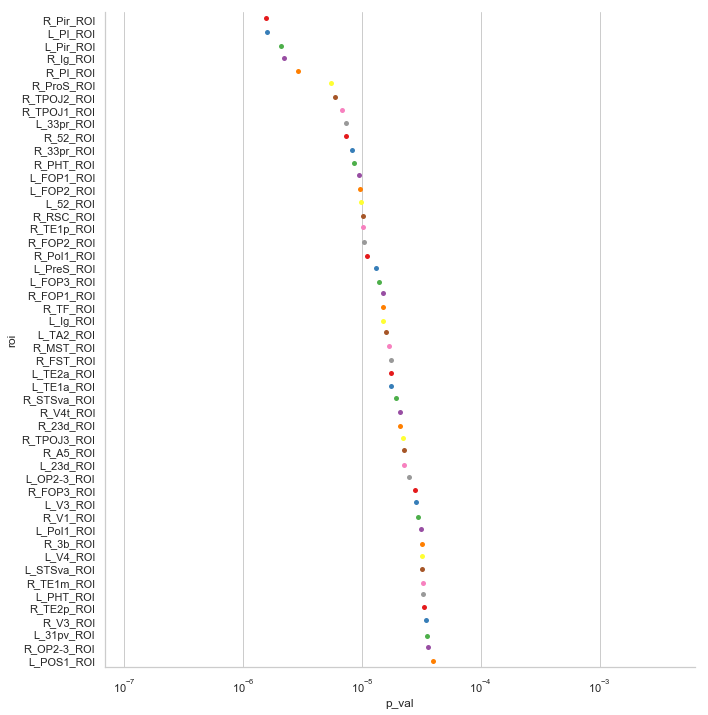

In [26]:
# Plots
aparc = 'Glasser'
p_thesh = 0.1
top_rois = 50
plot_df = stat_perf_dict[aparc].sort_values(by=['p_val']).head(top_rois)

sns.set(font_scale=1)
with sns.axes_style("whitegrid"):
    g = sns.catplot(x='p_val',y='roi',kind='strip',
                    data=plot_df,palette='Set1',height=10)
    g.set(xscale="log");

In [60]:
from nilearn import datasets
from nilearn import plotting

In [82]:
destrieux_atlas

{'labels': [b'Unknown',
  b'G_and_S_frontomargin',
  b'G_and_S_occipital_inf',
  b'G_and_S_paracentral',
  b'G_and_S_subcentral',
  b'G_and_S_transv_frontopol',
  b'G_and_S_cingul-Ant',
  b'G_and_S_cingul-Mid-Ant',
  b'G_and_S_cingul-Mid-Post',
  b'G_cingul-Post-dorsal',
  b'G_cingul-Post-ventral',
  b'G_cuneus',
  b'G_front_inf-Opercular',
  b'G_front_inf-Orbital',
  b'G_front_inf-Triangul',
  b'G_front_middle',
  b'G_front_sup',
  b'G_Ins_lg_and_S_cent_ins',
  b'G_insular_short',
  b'G_occipital_middle',
  b'G_occipital_sup',
  b'G_oc-temp_lat-fusifor',
  b'G_oc-temp_med-Lingual',
  b'G_oc-temp_med-Parahip',
  b'G_orbital',
  b'G_pariet_inf-Angular',
  b'G_pariet_inf-Supramar',
  b'G_parietal_sup',
  b'G_postcentral',
  b'G_precentral',
  b'G_precuneus',
  b'G_rectus',
  b'G_subcallosal',
  b'G_temp_sup-G_T_transv',
  b'G_temp_sup-Lateral',
  b'G_temp_sup-Plan_polar',
  b'G_temp_sup-Plan_tempo',
  b'G_temporal_inf',
  b'G_temporal_middle',
  b'Lat_Fis-ant-Horizont',
  b'Lat_Fis-ant-V

In [61]:
destrieux_atlas = datasets.fetch_atlas_surf_destrieux()

# The parcellation is already loaded into memory
parcellation = destrieux_atlas['map_left']

# Retrieve fsaverage5 surface dataset for the plotting background. It contains
# the surface template as pial and inflated version and a sulcal depth maps
# which is used for shading
fsaverage = datasets.fetch_surf_fsaverage()

# The fsaverage dataset contains file names pointing to the file locations
print('Fsaverage5 pial surface of left hemisphere is at: %s' %
      fsaverage['pial_left'])
print('Fsaverage5 inflated surface of left hemisphere is at: %s' %
      fsaverage['infl_left'])
print('Fsaverage5 sulcal depth map of left hemisphere is at: %s' %
      fsaverage['sulc_left'])

Fsaverage5 pial surface of left hemisphere is at: /Users/nikhil/anaconda/envs/analytics_pipeline/lib/python3.6/site-packages/nilearn/datasets/data/fsaverage5/pial.left.gii.gz
Fsaverage5 inflated surface of left hemisphere is at: /Users/nikhil/anaconda/envs/analytics_pipeline/lib/python3.6/site-packages/nilearn/datasets/data/fsaverage5/pial_inflated.left.gii.gz
Fsaverage5 sulcal depth map of left hemisphere is at: /Users/nikhil/anaconda/envs/analytics_pipeline/lib/python3.6/site-packages/nilearn/datasets/data/fsaverage5/sulc.left.gii.gz


In [70]:
def get_nilearn_label_format(labels):
    ''' Check label format from freesurfer tables and convert it to nilearn format
        Main differences are 1) prefix of 'L' and 'R' vs format char 'b' 2) '&' char instead of the word 'and'
    '''
    labels_std_L = []
    labels_std_R = []
    for label in labels:
        label_split = label.split('_',1)
        label_std = label_split[1]
        label_std = label_std.replace('&', '_and_')
        
        if label_split[0] == 'L':
            labels_std_L.append(bytes(label_std, encoding= 'utf-8'))
        elif label_split[0] == 'R':
            labels_std_R.append(bytes(label_std, encoding= 'utf-8'))
        else:
            print('unknown ROI label {}'.format(label))
            
    return labels_std_L, labels_std_R


In [73]:
p_thresh = 0.2
stat_df = stat_perf_dict['Destrieux']
signific_rois = stat_df[stat_df['p_val'] < p_thresh]['roi'].values
print('Number of signficant ROIs {}'.format(len(signific_rois)))
plot_regions_L,plot_regions_R = get_nilearn_label_format(signific_rois)
print('plot regions \nleft: {}, \nright: {}'.format(plot_regions_L,plot_regions_R))

Number of signficant ROIs 17
plot regions 
left: [b'G_and_S_transv_frontopol', b'G_cingul-Post-ventral', b'G_cuneus', b'G_oc-temp_med-Lingual', b'G_rectus', b'G_temp_sup-Lateral', b'Lat_Fis-ant-Vertical', b'Lat_Fis-post', b'Pole_occipital', b'S_calcarine', b'S_collat_transv_ant', b'S_orbital_med-olfact', b'S_suborbital'], 
right: [b'G_temp_sup-Lateral', b'Pole_occipital', b'S_collat_transv_post', b'S_subparietal']


In [77]:
#parcellation.shape
labels = destrieux_atlas['labels']

# Extract seed region via label
plot_labels = []
for roi in plot_regions_L:
    plot_labels.append(np.where(parcellation == labels.index(roi))[0])

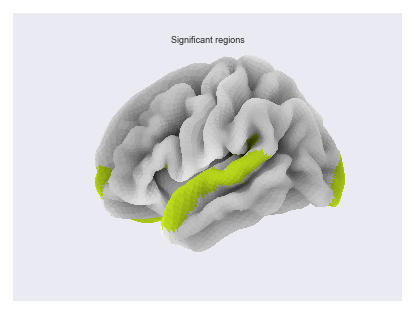

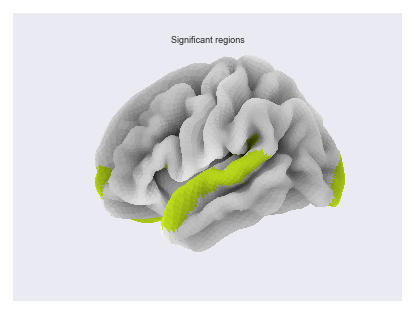

In [79]:

plotting.plot_surf_roi(fsaverage['pial_left'], roi_map=np.hstack(plot_labels),
                       hemi='left', view='lateral',
                       bg_map=fsaverage['sulc_left'], bg_on_data=True,
                       title='Significant regions')

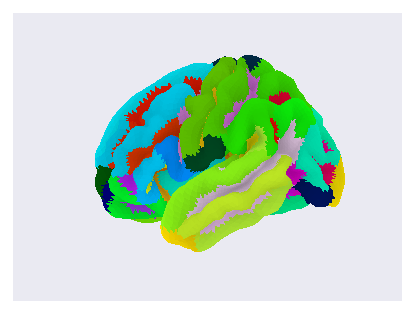

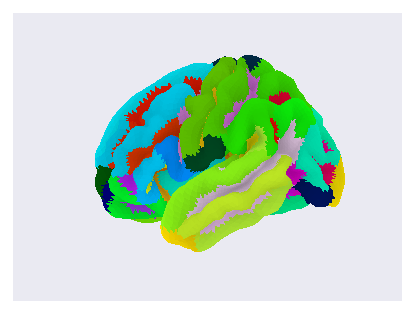

In [40]:
# Display Destrieux parcellation on fsaverage5 pial surface using nilearn
from nilearn import plotting

plotting.plot_surf_roi(fsaverage['pial_left'], roi_map=parcellation,
                       hemi='left', view='lateral',
                       bg_map=fsaverage['sulc_left'], bg_on_data=True,
                       darkness=.5)

In [42]:
view = plotting.view_surf(fsaverage.infl_left, parcellation,
                          cmap='gist_ncar', symmetric_cmap=False)
# uncomment this to open the plot in a web browser:
view